<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/ML/2_6_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 2. Machine Learning

## 2.6 Unsupervised Learning

### 2.6.1 Clustering Algorithms

As you enjoy a hike in the mountains, you stumble upon a plant you have never seen before. You look around and you notice a few more. They are not identical, yet they are sufficiently similar for you to know that they most likely belong to the same species (or at least the same genus). You may need a botanist to tell you what species that is, but you certainly don’t need an expert to identify groups of similar-looking objects. This is called *clustering*: it is the task of identifying similar instances and assigning them to *clusters*, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification, clustering is an unsupervised task, there are no labels, so the algorithm needs to figure out on its own how to group instances. Consider the next figure: on the left is the iris dataset, where each instance’s species (i.e., its class) is represented with a different marker. It is a labeled dataset, for which classification algorithms such as logistic regression, SVMs, or random forest classifiers are well suited. On the right is the same dataset, but without the labels, so you cannot use a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct subclusters. That said, the dataset has two additional features (sepal length and width) that are not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

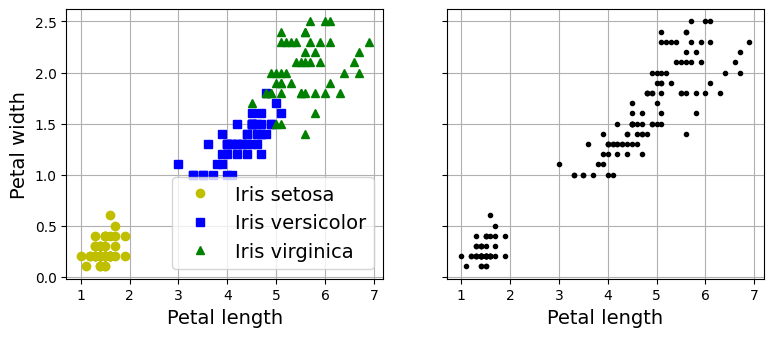

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

**Note**: the next cell shows how a Gaussian mixture model can actually separate these clusters pretty well using all 4 features: petal length & width, and sepal length & width. This code maps each cluster to a class. Instead of hard coding the mapping, the code picks the most common class for each cluster using the `scipy.stats.mode()` function:

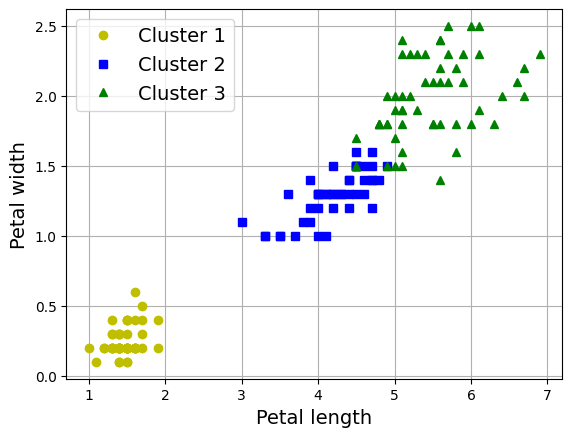

In [3]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

What's the ratio of iris plants we assigned to the right cluster?

In [4]:
(y_pred==y).sum() / len(y_pred)

np.float64(0.9666666666666667)

Clustering is used in a wide variety of applications, including:

*Dimensionality reduction*:

Once a dataset has been clustered, it is usually possible to measure each instance’s *affinity* with each cluster; affinity is any measure of how well an instance fits into a cluster. Each instance’s feature vector $\mathbf{x}$ can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. The new vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.

*Anomaly detection (also called outlier detection)*:

Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second.

*Semi-supervised learning*:

If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This technique can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

There is no universal definition of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters. Some algorithms look for instances centered around a particular point, called a *centroid*. Others look for continuous regions of densely packed instances: these clusters can take on any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

#### 2.6.1.1 K-Means

Consider the unlabeled dataset represented in the following plot: you can clearly see five blobs of instances. The *k*-means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations.

In [5]:
from sklearn.datasets import make_blobs

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

# make the blobs: y contains the cluster IDs, but we
# will not use them; that's what we want to predict
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

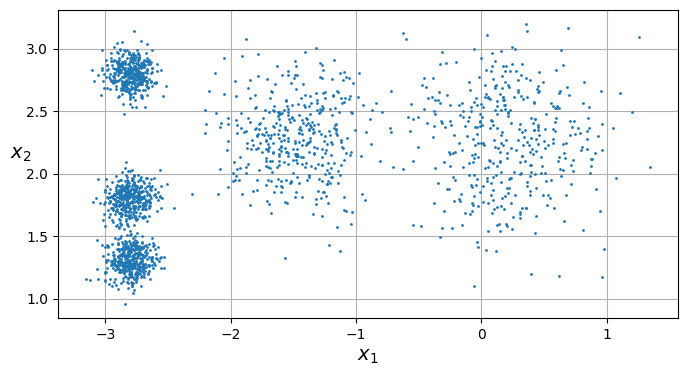

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

Let’s train a k-means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob:

In [7]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=43)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy.

Each instance will be assigned to one of the five clusters. In the context of clustering, an instance’s *label* is the index of the cluster to which the algorithm assigns this instance; this is not to be confused with the class labels in classification, which are used as targets (remember that clustering is an unsupervised learning task). The `KMeans` instance preserves the predicted labels of the instances it was trained on, available via the `labels_` instance variable:

In [8]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [9]:
y_pred is kmeans.labels_

True

And the following 5 *centroids* (i.e., cluster centers) were estimated:

In [10]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Of course, we can predict the labels of new instances:

In [11]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

If you plot the cluster’s decision boundaries, you get a Voronoi tessellation, where each centroid is represented with an ⓧ.

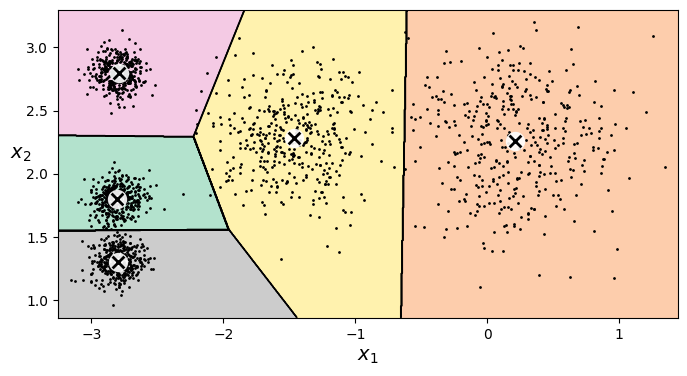

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

Rather than arbitrarily choosing the closest cluster for each instance, which is called *hard clustering*, it might be better to measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [13]:
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

**The k-means algorithm**:

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:

* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The algorithm is guaranteed to converge in a finite number of steps (usually quite small). That’s because the mean squared distance between the instances and their closest centroids can only go down at each step, and since it cannot be negative, it’s guaranteed to converge.

The KMeans class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

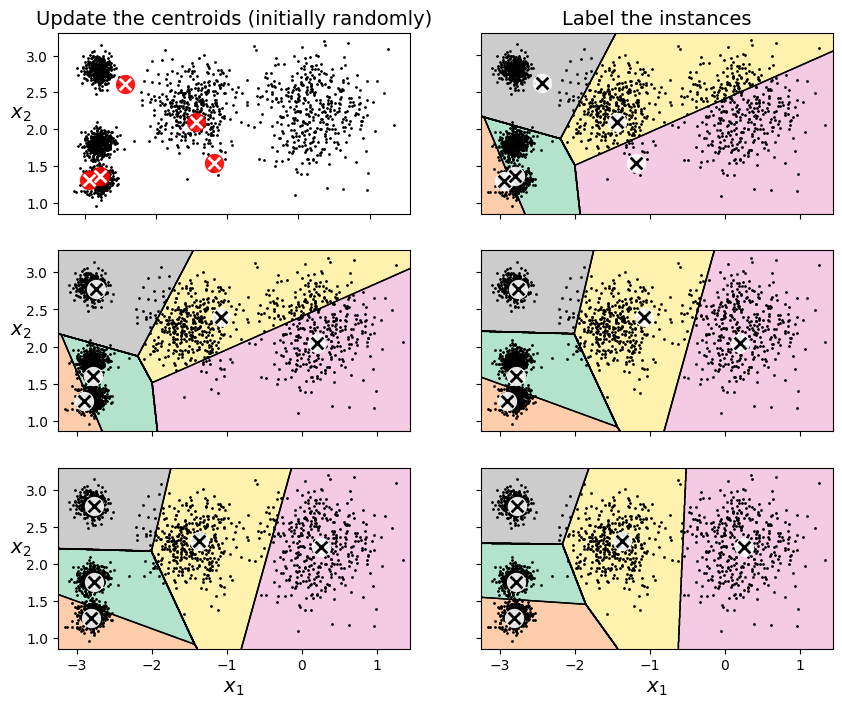

In [14]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=18)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=18)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=18)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)


plt.show()

**K-means variability**:

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

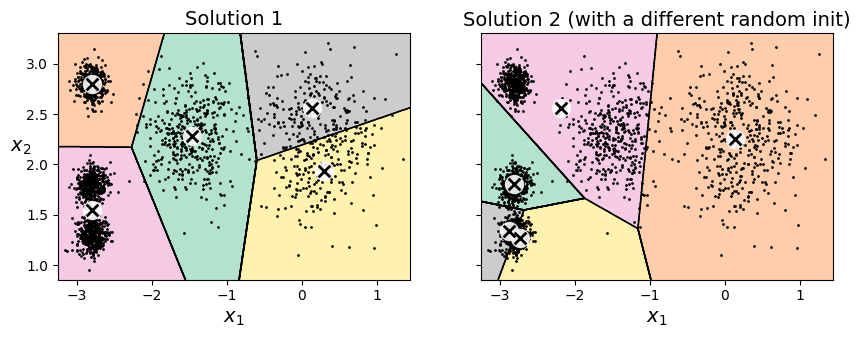

In [15]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=8)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")


plt.show()

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the `init` hyperparameter to a NumPy array containing the list of centroids:

In [16]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, random_state=42)

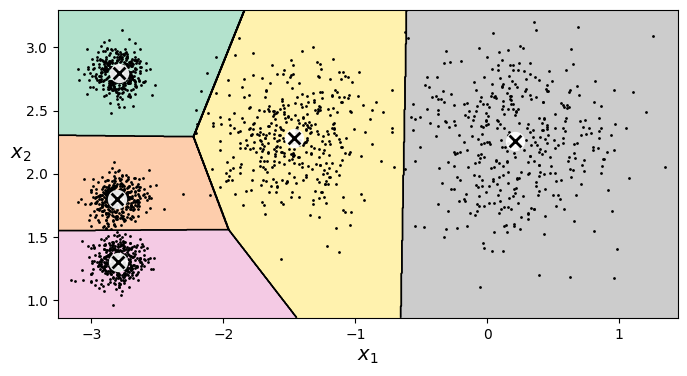

In [17]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

**Inertia**:

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the inertia metric:

$$\text{inertia} = \sum_{i} \|\mathbf{x}^{(i)} - \mathbf{c}^{(i)}\|^2$$

In [18]:
kmeans.inertia_

211.59853725816828

In [19]:
kmeans_rnd_init1.inertia_

219.58201503602285

In [20]:
kmeans_rnd_init2.inertia_

600.3600713094229

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the *"greater is better"* rule.

In [21]:
kmeans.score(X)

-211.59853725816828

**Multiple Initializations**:

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

Scikit-Learn runs the initialization algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=1` if `init="k-means++"` (which is the default) or if `init` is an array, or it sets `n_init=10` if `init="random"` or `init` is a callable.

In [22]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

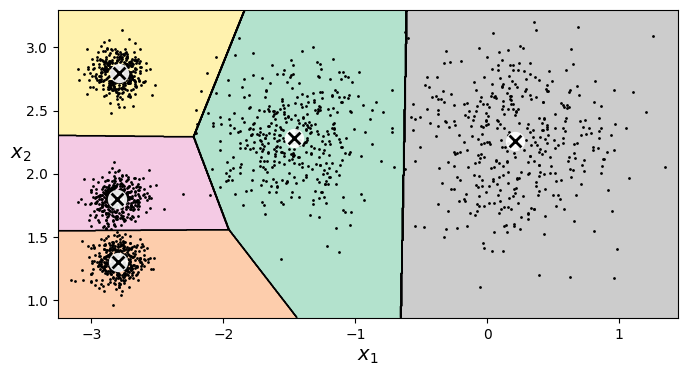

In [23]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [24]:
kmeans_rnd_10_inits.inertia_

211.59853725816828

**Centroid Initialization Methods**:

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm:

* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably (as mentionned earlier, `n_init` defaults to 1 when using `init=k-means++`. Most of the time, the fact that we can run way less initializations largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

**Accelerated K-Means**:

The K-Means algorithm can sometimes be accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids.

For Elkan's variant of K-Means, use `algorithm="elkan"`. For regular KMeans, use `algorithm="lloyd"` (this is the default).

**Finding the Optimal Number of Clusters**:

What if the number of clusters was set to a lower or greater value than 5?

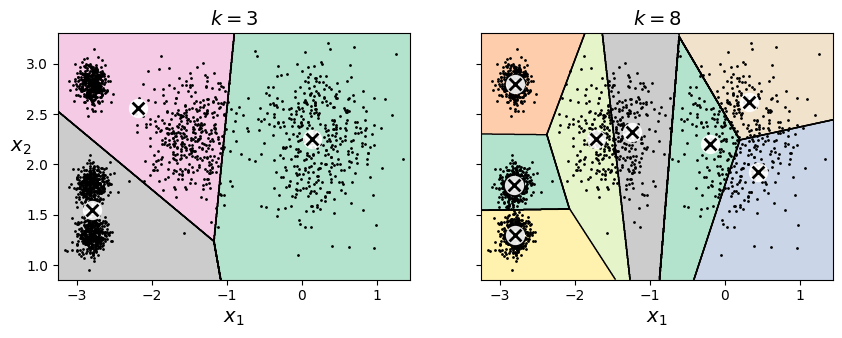

In [25]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

plt.show()

Ouch, these two models don't look great. What about their inertias?

In [26]:
kmeans_k3.inertia_

653.2167190021554

In [27]:
kmeans_k8.inertia_

127.13141880461835

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

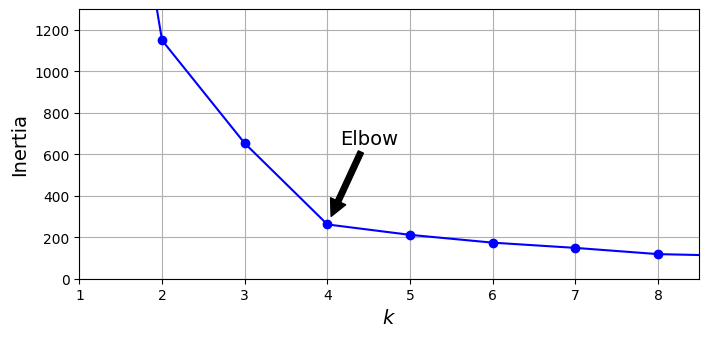

In [28]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=43).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()

plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

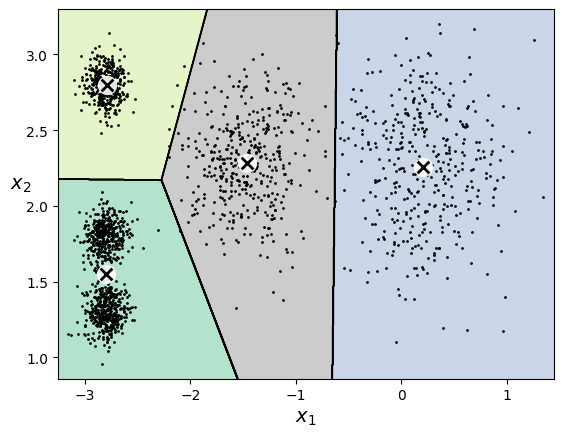

In [29]:
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to (_b_ - _a_) / max(_a_, _b_) where _a_ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and _b_ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes _b_, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [30]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

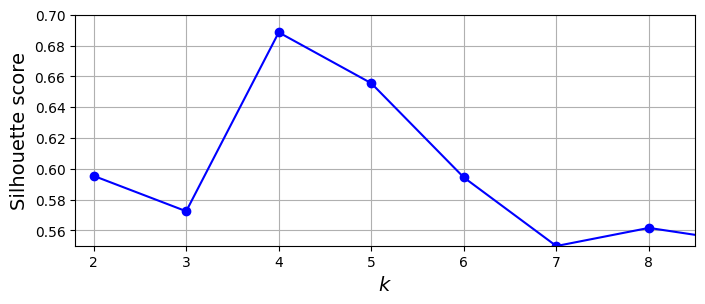

In [31]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()

plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_. Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better).

The vertical dashed lines represent the mean silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. Here we can see that when $k = 3$ or $6$, we get bad clusters. But when $k = 4$ or $5$, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to $1.0$. When $k = 4$, the cluster at index 0 (at the bottom) is rather big. When $k = 5$, all clusters have similar sizes. So, even though the overall silhouette score from $k = 4$ is slightly greater than for $k = 5$, it seems like a good idea to use $k = 5$ to get clusters of similar sizes.

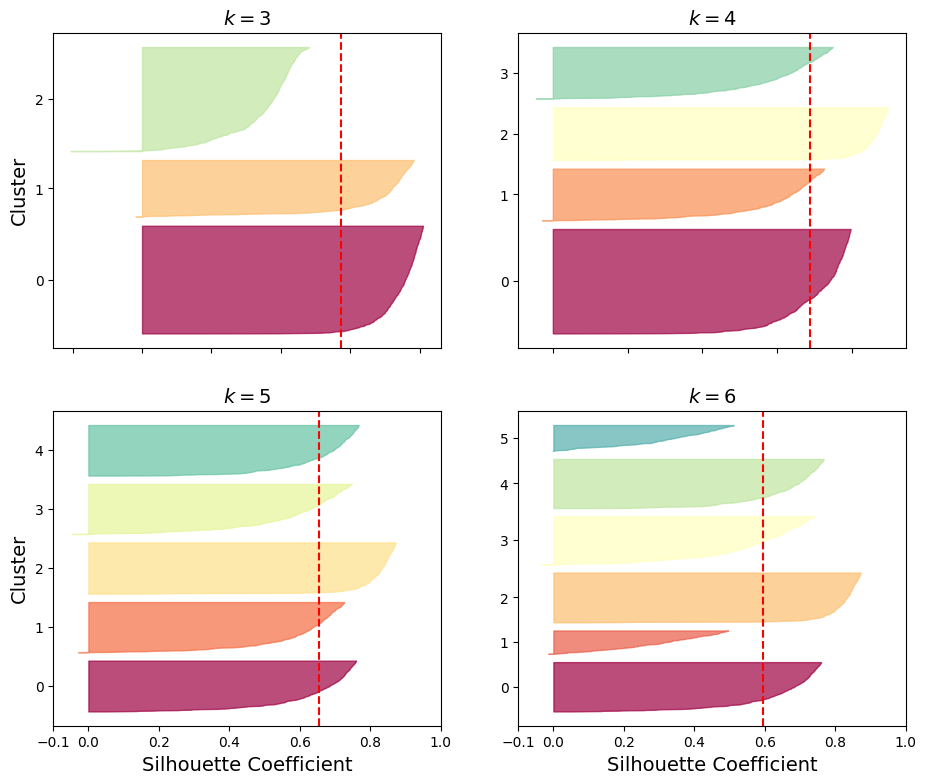

In [32]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")


plt.show()

**Limits of K-Means**:

*k-means* does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. Let's generate a more difficult dataset, with elongated blobs and varying densities, and show that K-Means struggles to cluster it correctly:

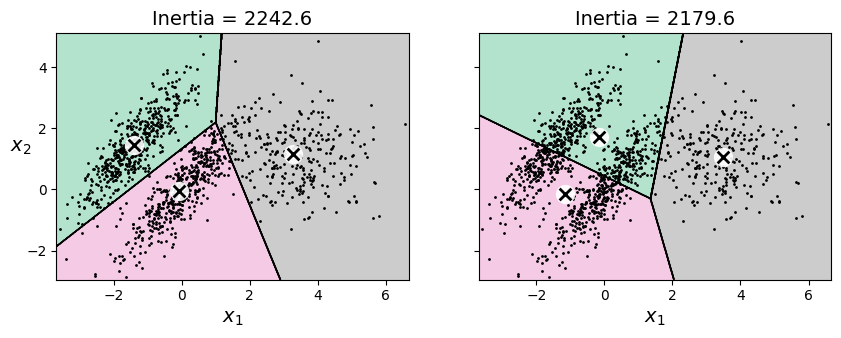

In [33]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")


plt.show()

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

**Note**: It is important to scale the input features before running k-means, or the clusters may be very stretched and k-means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally helps.

#### 2.6.1.2 DBSCAN

The *density-based spatial clustering of applications with noise* (DBSCAN) algorithm defines clusters as continuous regions of high density. Here is how it works:

* For each instance, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. This region is called the instance’s $\epsilon$-neighborhood.
* If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.
* All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
* Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.
* This algorithm works well if all the clusters are well separated by low-density regions. The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the `labels_` instance variable:

In [35]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instances have a cluster index equal to –1, which means that they are considered as anomalies by the algorithm. The indices of the core instances are available in the `core_sample_indices_` instance variable, and the core instances themselves are available in the `components_` instance variable:

In [36]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [37]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

This clustering is represented in the lefthand plot. As you can see, it identified quite a lot of anomalies, plus seven different clusters. How disappointing! Fortunately, if we widen each instance’s neighborhood by increasing `eps` to 0.2, we get the clustering on the right, which looks perfect. Let’s continue with this model.

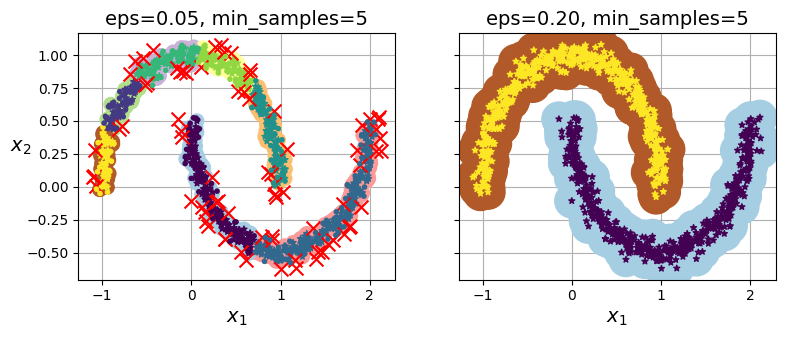

In [38]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)


plt.show()

In [39]:
dbscan = dbscan2

Surprisingly, the DBSCAN class does not have a `predict()` method, although it has a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to. This decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement. For example, let’s train a `KNeighborsClassifier`:

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which clusters they most likely belong to and even estimate a probability for each cluster:

In [41]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [42]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Note that we only trained the classifier on the core instances, but we could also have chosen to train it on all the instances, or all but the anomalies: this choice depends on the final task.

The decision boundary is represented in the following plot (the crosses represent the four instances in `X_new`). Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, use the `kneighbors()` method of the `KNeighborsClassifier`. Given a set of instances, it returns the distances and the indices of the k-nearest neighbors in the training set (two matrices, each with k columns):

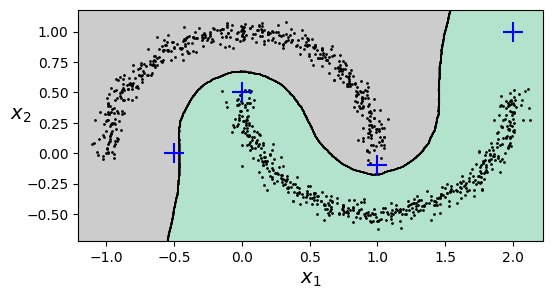

In [43]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

In [44]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters (`eps` and `min_samples`). If the density varies significantly across the clusters, however, or if there’s no sufficiently low-density region around some clusters, DBSCAN can struggle to capture all the clusters properly. Moreover, its computational complexity is roughly $O(m^2n)$, so it does not scale well to large datasets.

**Tip**: You may also want to try *hierarchical DBSCAN* (HDBSCAN), using `sklearn.cluster.HDBSCAN`: it is often better than DBSCAN at finding clusters of varying densities.

### 2.6.2 Gaussian Mixtures

A *Gaussian mixture model* (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation. When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the `GaussianMixture` class, you must know in advance the number $k$ of Gaussian distributions. The dataset $\mathbf{X}$ is assumed to have been generated through the following probabilistic process:

* For each instance, a cluster is picked randomly from among $k$ clusters. The probability of choosing the $j$-th cluster is the cluster’s weight $\phi^{(j)}$.⁠The index of the cluster chosen for the $i$-th instance is denoted $z^{(i)}$.
* If the $i$-th instance was assigned to the $j$-th cluster (i.e., $z^{(i)} = j$), then the location $\mathbf{x}^{(i)}$ of this instance is sampled randomly from the Gaussian distribution with mean $\mu^{(j)}$ and covariance matrix $\Sigma^{(j)}$. This is denoted $\mathbf{x}^{(i)} \sim \mathcal{N}(\mu^{(j)}, \Sigma^{(j)})$.

So what can you do with such a model? Well, given the dataset $\mathbf{X}$, you typically want to start by estimating the weights $\phi$ and all the distribution parameters $\mu^{(1)}$ to $\mu^{(k)}$ and $\Sigma^{(1)}$ to $\Sigma^{(k)}$. Scikit-Learn’s GaussianMixture class makes this super easy. Let's train a Gaussian mixture model on the previous dataset:

In [45]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [46]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let’s look at the parameters that the algorithm estimated:

In [47]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [48]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [49]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Great, it worked fine! Indeed, two of the three clusters were generated with 500 instances each, while the third cluster only contains 250 instances. So the true cluster weights are 0.4, 0.4, and 0.2, respectively, and that’s roughly what the algorithm found (in a different order). Similarly, the true means and covariance matrices are quite close to those found by the algorithm. But how? This class relies on the *expectation-maximization* (EM) algorithm, which has many similarities with the *k*-means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigning instances to clusters (this is called the *expectation step*) and then updating the clusters (this is called the *maximization step*). Sounds familiar, right? In the context of clustering, you can think of EM as a generalization of *k*-means that not only finds the cluster centers $(\mu^{(1)}$ to $μ(k))$, but also their size, shape, and orientation $(\Sigma^{(1)}$ to $\Sigma^{(k)})$, as well as their relative weights $(\phi^{(1)}$ to $\phi^{(k)})$. Unlike *k*-means, though, EM uses soft cluster assignments, not hard assignments. For each instance, during the expectation step, the algorithm estimates the probability that it belongs to each cluster (based on the current cluster parameters). Then, during the maximization step, each cluster is updated using all the instances in the dataset, with each instance weighted by the estimated probability that it belongs to that cluster. These probabilities are called the responsibilities of the clusters for the instances. During the maximization step, each cluster’s update will mostly be impacted by the instances it is most responsible for.

**Warning**: Unfortunately, just like *k*-means, EM can end up converging to poor solutions, so it needs to be run several times, keeping only the best solution. This is why we set `n_init` to 10. Be careful: by default `n_init` is set to 1.

Did the algorithm actually converge?

In [50]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [51]:
gm.n_iter_

4

A Gaussian mixture model is a *generative model*, meaning you can sample new instances from it (note that they are ordered by cluster index):

In [52]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

It is also possible to estimate the density of the model at any given location. This is achieved using the `score_samples()` method: for each instance it is given, this method estimates the log of the *probability density function* (PDF) at that location. The greater the score, the higher the density:

In [53]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

If you compute the exponential of these scores, you get the value of the PDF at the location of the given instances. These are not probabilities, but probability *densities*: they can take on any positive value, not just a value between 0 and 1. To estimate the probability that an instance will fall within a particular region, you would have to integrate the PDF over that region (if you do so over the entire space of possible instance locations, the result will be 1).

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [54]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225088)

The following plot shows the cluster means, the decision boundaries (dashed lines), and the density contours of this model.

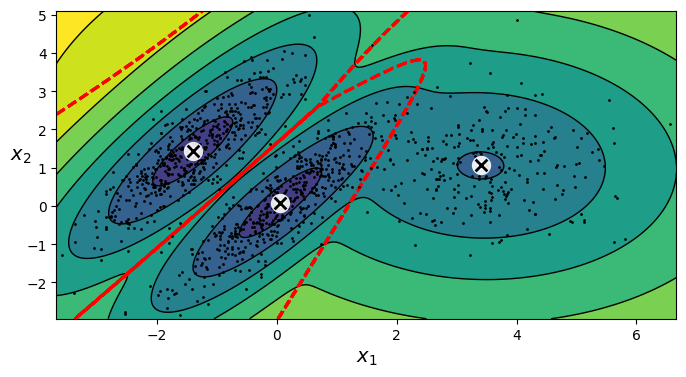

In [55]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)


plt.show()

Nice! The algorithm clearly found an excellent solution. Of course, we made its task easy by generating the data using a set of 2D Gaussian distributions (unfortunately, real-life data is not always so Gaussian and low-dimensional). We also gave the algorithm the correct number of clusters. When there are many dimensions, or many clusters, or few instances, EM can struggle to converge to the optimal solution. You might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constraints on the covariance matrices. To do this, set the `covariance_type` hyperparameter to one of the following values:

* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.

By default, `covariance_type` is equal to `"full"`, which means that each cluster can take on any shape, size, and orientation (it has its own unconstrained covariance matrix). The next figures plot the solutions found by the EM algorithm when `covariance_type` is set to `"tied"`, `"spherical"`, `"full"` and `"diag"`.

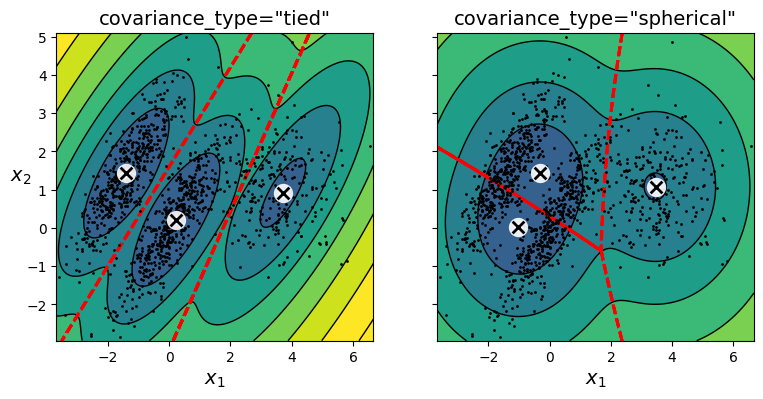

In [56]:
gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)


plt.show()

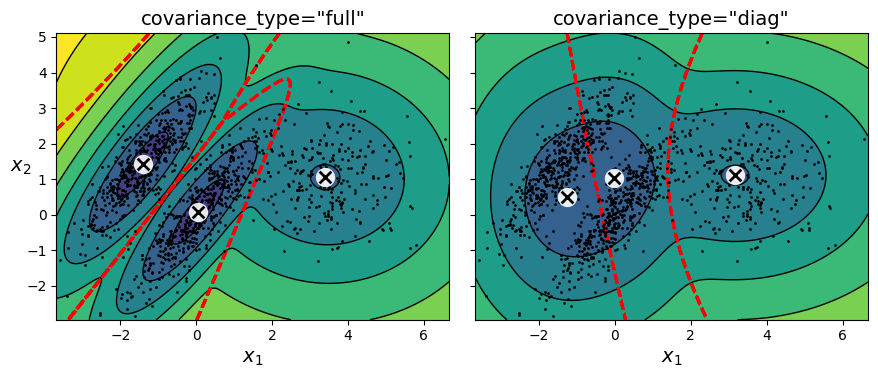

In [57]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

#### 2.6.2.1 Using Gaussian Mixtures for Anomaly Detection

Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well known. Say it is equal to 2%. You then set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density. If you notice that you get too many false positives (i.e., perfectly good products that are flagged as defective), you can lower the threshold. Conversely, if you have too many false negatives (i.e., defective products that the system does not flag as defective), you can increase the threshold. This is the usual precision/recall trade-off. Here is how you would identify the outliers using the second percentile lowest density as the threshold (i.e., approximately 2% of the instances will be flagged as anomalies):

In [58]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

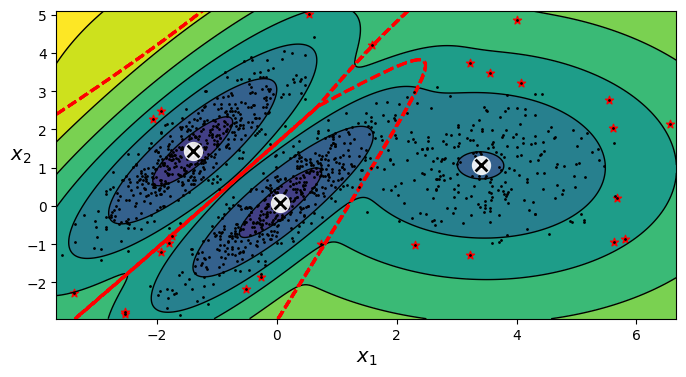

In [59]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)


plt.show()

**Tip**: Gaussian mixture models try to fit all the data, including the outliers; if you have too many of them this will bias the model’s view of “normality”, and some outliers may wrongly be considered as normal. If this happens, you can try to fit the model once, use it to detect and remove the most extreme outliers, then fit the model again on the cleaned-up dataset. Another approach is to use robust covariance estimation methods (see the `EllipticEnvelope` class).

#### 2.6.2.2 Selecting the Number of Clusters

With *k*-means, you can use the inertia or the silhouette score to select the appropriate number of clusters. But with Gaussian mixtures, it is not possible to use these metrics because they are not reliable when the clusters are not spherical or have different sizes. Instead, you can try to find the model that minimizes a *theoretical information criterion*, such as the *Bayesian information criterion* (BIC) or the *Akaike information criterion* (AIC).

$${BIC} = {\log(m)p - 2\log({\hat L})}$$

$${AIC} = 2p - 2\log(\hat L)$$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data). They often end up selecting the same model. When they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends to not fit the data quite as well (this is especially true for larger datasets).

**Likelihood function**: The terms “probability” and “likelihood” are often used interchangeably in everyday language, but they have very different meanings in statistics. Given a statistical model with some parameters $\mathbf{\theta}$, the word “probability” is used to describe how plausible a future outcome $\mathbf{x}$ is (knowing the parameter values $\mathbf{\theta}$), while the word “likelihood” is used to describe how plausible a particular set of parameter values $\mathbf{\theta}$ are, after the outcome $\mathbf{x}$ is known.

Consider a 1D mixture model of two Gaussian distributions centered at –4 and +1. For simplicity, this toy model has a single parameter $\theta$ that controls the standard deviations of both distributions. The top-left contour plot shows the entire model $f(x; \theta)$ as a function of both $x$ and $\theta$. To estimate the probability distribution of a future outcome $x$, you need to set the model parameter $\theta$. For example, if you set $\theta$ to 1.3 (the horizontal line), you get the probability density function $f(x; \theta = 1.3)$ shown in the lower-left plot. Say you want to estimate the probability that $x$ will fall between –2 and +2. You must calculate the integral of the PDF on this range (i.e., the surface of the shaded region). But what if you don’t know $\theta$, and if instead you have observed a single instance $x = 2.5$ (the vertical line in the upper-left plot)? In this case, you get the likelihood function $L(\theta|x = 2.5) = f(x = 2.5; \theta)$, represented in the upper-right plot.

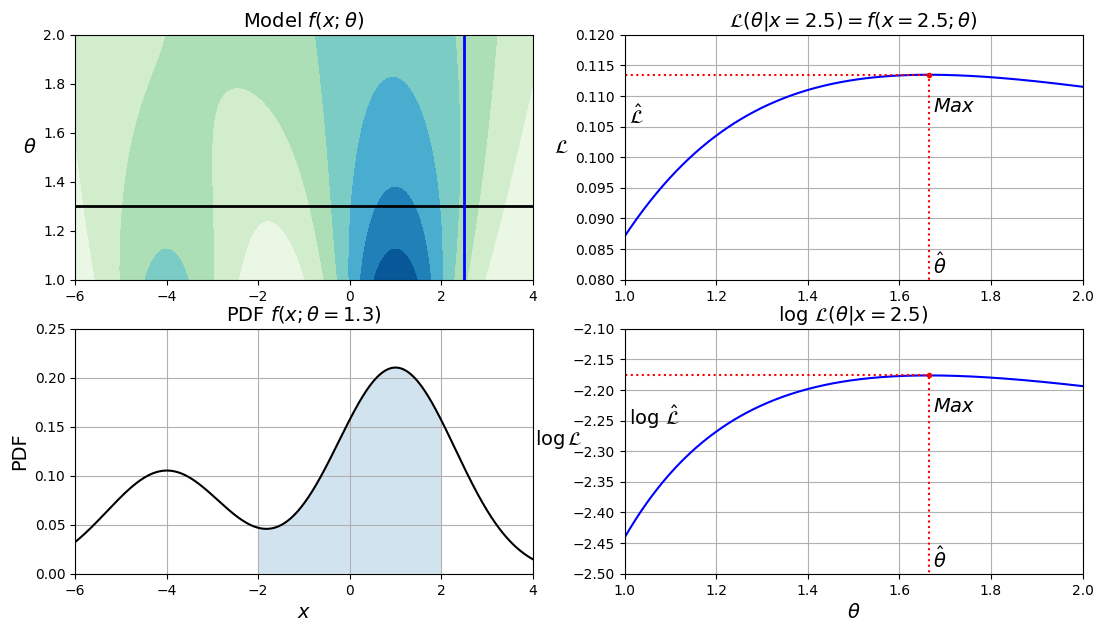

In [60]:
from scipy.stats import norm

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

x_example_idx = (xs >= x_val).argmax()  # index of the first value >= x_val
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
s_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

plt.figure(figsize=(13, 7))

plt.subplot(2, 2, 1)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"Model $f(x; \theta)$")

plt.subplot(2, 2, 2)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx]+ 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx]+ 0.01, max_val - 0.006, r"$Max$")
plt.text(1.01, max_val - 0.008, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")
plt.grid()
plt.axis((1, 2, 0.08, 0.12))

plt.subplot(2, 2, 3)
plt.plot(xs, Z[s_example_idx], "k-")
plt.fill_between(xs[x_range_min_idx:x_range_max_idx+1],
                 Z[s_example_idx, x_range_min_idx:x_range_max_idx+1], alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(fr"PDF $f(x; \theta={std_val})$")
plt.grid()
plt.axis((-6, 4, 0, 0.25))

plt.subplot(2, 2, 4)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(stds[log_max_idx]+ 0.01, log_max_val - 0.06, r"$Max$")
plt.text(stds[log_max_idx]+ 0.01, -2.49, r"$\hat{\theta}$")
plt.text(1.01, log_max_val - 0.08, r"$\log \, \hat{\mathcal{L}}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")
plt.grid()
plt.axis((1, 2, -2.5, -2.1))


plt.show()

In short, the PDF is a function of $x$ (with $\theta$ fixed), while the likelihood function is a function of $\theta$ (with $x$ fixed). It is important to understand that the likelihood function is *not* a probability distribution: if you integrate a probability distribution over all possible values of $x$, you always get 1, but if you integrate the likelihood function over all possible values of $\theta$, the result can be any positive value.

Given a dataset $\mathbf{X}$, a common task is to try to estimate the most likely values for the model parameters. To do this, you must find the values that maximize the likelihood function, given $\mathbf{X}$. In this example, if you have observed a single instance $x = 2.5$, the *maximum likelihood estimate* (MLE) of $\theta$ is $\hat{\theta} \approx 1.66$. If a prior probability distribution $g$ over $\theta$ exists, it is possible to take it into account by maximizing $\mathcal{L}(\theta|x)g(\theta)$ rather than just maximizing $\mathcal{L}(\theta|x)$. This is called *maximum a-posteriori* (MAP) estimation. Since MAP constrains the parameter values, you can think of it as a regularized version of MLE.

Notice that maximizing the likelihood function is equivalent to maximizing its logarithm (represented in the lower-right plot). Indeed, the logarithm is a strictly increasing function, so if $\theta$ maximizes the log likelihood, it also maximizes the likelihood. It turns out that it is generally easier to maximize the log likelihood. For example, if you observed several independent instances $x^{(1)}$ to $x^{(m)}$, you would need to find the value of $\theta$ that maximizes the product of the individual likelihood functions. But it is equivalent, and much simpler, to maximize the sum (not the product) of the log likelihood functions, thanks to the magic of the logarithm which converts products into sums: $\log(ab) = \log(a) + \log(b)$.

Once you have estimated $\hat{\theta}$, the value of $\theta$ that maximizes the likelihood function, then you are ready to compute $\hat{\mathcal{L}} = \mathcal{L}(\hat{\theta}|\mathbf{X})$, which is the value used to compute the AIC and BIC; you can think of it as a measure of how well the model fits the data.

To compute the BIC and AIC, call the `bic()` and `aic()` methods:

In [61]:
gm.bic(X)

np.float64(8189.733705221636)

In [62]:
gm.aic(X)

np.float64(8102.508425106598)

The next plot shows the BIC for different numbers of clusters $k$. As you can see, both the BIC and the AIC are lowest when $k = 3$, so it is most likely the best choice.

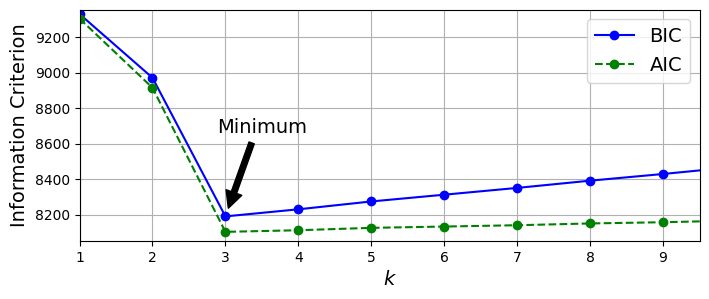

In [63]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()

plt.show()

#### 2.6.2.3 Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, you can use the `BayesianGaussianMixture` class, which is capable of giving weights equal (or close) to zero to unnecessary clusters. Set the number of clusters `n_components` to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge about the problem at hand), and the algorithm will eliminate the unnecessary clusters automatically. For example, let’s set the number of clusters to 10 and see what happens:

In [64]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, max_iter=500,
                              random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

The algorithm automatically detected that only 3 components are needed!

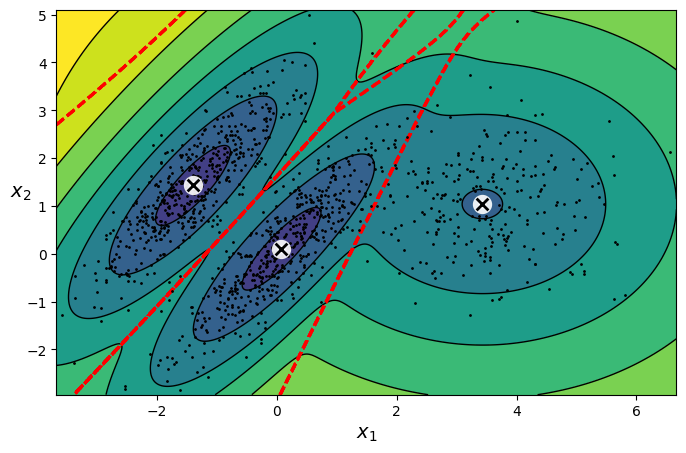

In [65]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

A final note about Gaussian mixture models: although they work great on clusters with ellipsoidal shapes, they don’t do so well with clusters of very different shapes. For example, let’s see what happens if we use a Bayesian Gaussian mixture model to cluster the moons dataset:

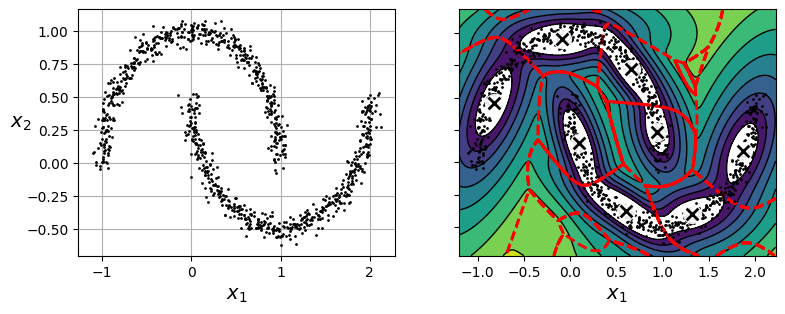

In [66]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, max_iter=500, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid()

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)


plt.show()

Oops! The algorithm desperately searched for ellipsoids, so it found eight different clusters instead of two. The density estimation is not too bad, so this model could perhaps be used for anomaly detection, but it failed to identify the two moons.

#### **For Further Exploration**

Check out these resources to deepen your understanding of unsupervised learning and clustering:

* [Supervised vs. Unsupervised Learning](https://youtu.be/W01tIRP_Rqs?si=y_BE6HY3nXiAxMk2)
* [StatQuest: K-means clustering](https://youtu.be/4b5d3muPQmA?si=H1UeX_9u0tBka6Wa)
* [Gaussian Mixture Models (GMM) Explained](https://youtu.be/wT2yLNUfyoM?si=BGJ2ID1qLsg2LLjC)

---

**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 8 Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron, [3rd edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

---

**Assignment 2a**:

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).

2. Tackle the [Titanic dataset](https://homl.info/titanic.tgz), or download from [Kaggle](https://www.kaggle.com/c/titanic). This will give you two CSV files, train.csv and test.csv, which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns.

OR

Build a spam classifier (a more challenging exercise).
* Download [examples of spam and ham](https://homl.info/spamassassin).
* Unzip the datasets and familiarize yourself with the data format.
* Split the data into a training set and a test set.
* Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello”, “how”, “are”, “you”, then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word. You may want to add hyperparameters to your preparation pipeline to control whether to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL”, replace all numbers with “NUMBER”, or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
* Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.


**Assignment 2b**:

1. The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. Forty different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you will probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using k-means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). Visualize the clusters: do you see similar faces in each cluster? Comment and explain what you observe.

2. Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset’s dimensionality (e.g., use PCA, preserving 99% of the variance). Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method). Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies). Comment and explain what you observe.